In [1]:
pip install tensorflow

In [2]:
pip install optuna

In [3]:
pip install mlflow

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import optuna
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score, confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve, average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy.stats import randint, uniform

In [6]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving kickstarter_final_processed.csv to kickstarter_final_processed (1).csv


In [8]:
df = pd.read_csv("kickstarter_final_processed.csv")

In [9]:
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
goal_percentile_bin    26
dtype: int64


In [10]:
df=df.dropna()

##  Dropping Non-Numeric Columns and Define Features/Target

No non-numeric columns to drop.
Feature matrix shape: (14437, 169)
Target vector shape: (14437,)

Class distribution:
target
1    57.678188
0    42.321812
Name: proportion, dtype: float64


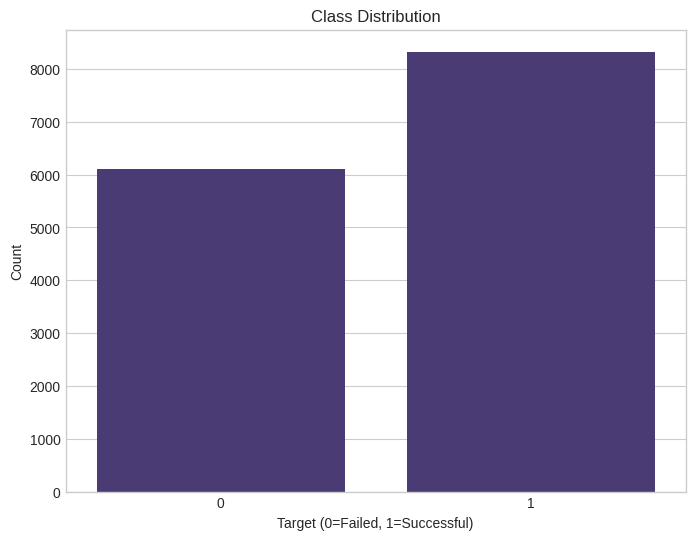

In [12]:
non_numeric_cols = df.select_dtypes(exclude=['int64', 'float64']).columns
if len(non_numeric_cols) > 0:
    print(f"Dropping {len(non_numeric_cols)} non-numeric columns: {list(non_numeric_cols)}")
    df = df.drop(columns=non_numeric_cols)
else:
    print("No non-numeric columns to drop.")

# Define target variable
y = df['target']

# Define features (all columns except target)
X = df.drop(columns=['target', 'state'], errors='ignore')

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Show class distribution
class_distribution = y.value_counts(normalize=True) * 100
print("\nClass distribution:")
print(class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Target (0=Failed, 1=Successful)')
plt.ylabel('Count')
plt.show()


## Train/Test Split

In [13]:
# Split data into train and test sets (80/20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)

print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True) * 100)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

Training set: 11549 samples
Test set: 2888 samples

Class distribution in training set:
target
1    57.675989
0    42.324011
Name: proportion, dtype: float64

Class distribution in test set:
target
1    57.686981
0    42.313019
Name: proportion, dtype: float64


## Feature Selection

Running feature importance selection using Random Forest...


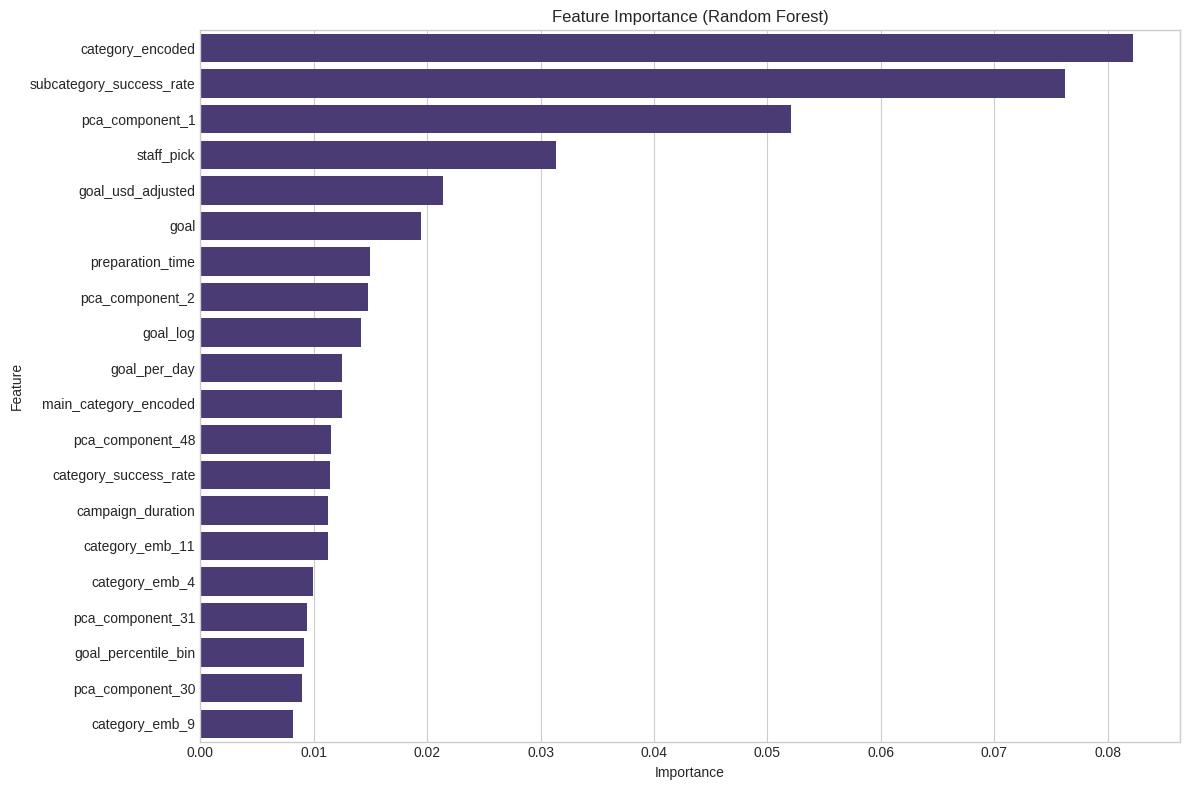


Running statistical feature selection with ANOVA F-test...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


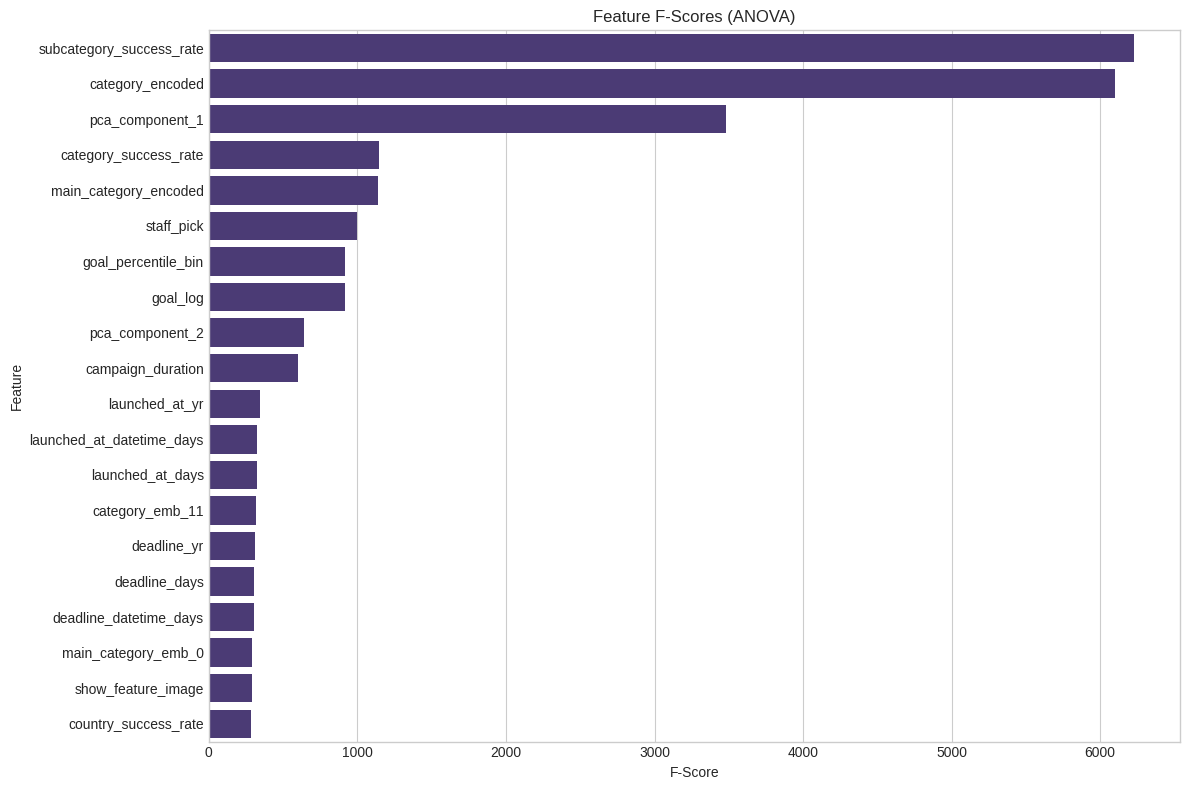


Running Recursive Feature Elimination with Cross-Validation...
Optimal number of features: 32
Selected 32 features using RFECV
['staff_pick', 'name_len', 'launched_at_yr', 'show_feature_image', 'video', 'campaign_duration', 'deadline_hour_cos', 'launched_at_hour_cos', 'goal_percentile_bin', 'goal_usd_adjusted', 'category_success_rate', 'subcategory_success_rate', 'country_success_rate', 'country_encoded', 'category_encoded', 'main_category_encoded', 'category_emb_3', 'main_category_emb_0', 'pca_component_1', 'pca_component_2', 'pca_component_7', 'pca_component_23', 'pca_component_24', 'pca_component_25', 'pca_component_29', 'pca_component_30', 'pca_component_31', 'pca_component_39', 'pca_component_40', 'pca_component_42', 'pca_component_48', 'pca_component_49']

Comparing feature selection methods:
Overlap between Random Forest and ANOVA: 14
Overlap between Random Forest and RFECV: 15
Overlap between ANOVA and RFECV: 18

Reduced feature matrix shape: (11549, 32)


In [14]:
# Start MLflow run
mlflow.start_run(run_name="feature_selection")

# Method 1: Feature importance using Random Forest
print("Running feature importance selection using Random Forest...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# Method 2: Statistical feature selection with ANOVA F-test
print("\nRunning statistical feature selection with ANOVA F-test...")
k_best = SelectKBest(f_classif, k=30)
k_best.fit(X_train_scaled, y_train)

# Get scores
f_scores = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'F-Score': k_best.scores_
}).sort_values('F-Score', ascending=False)

# Plot top 20 features by F-Score
plt.figure(figsize=(12, 8))
sns.barplot(x='F-Score', y='Feature', data=f_scores.head(20))
plt.title('Feature F-Scores (ANOVA)')
plt.tight_layout()
plt.show()

# Method 3: Recursive Feature Elimination with Cross-Validation
print("\nRunning Recursive Feature Elimination with Cross-Validation...")
# Use Logistic Regression for RFECV (faster than Random Forest)
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
rfecv = RFECV(
    estimator=lr,
    step=1,
    cv=StratifiedKFold(5),
    scoring='roc_auc',
    min_features_to_select=10,
    n_jobs=-1  # Use parallel processing
)

# Fit RFECV
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

# Get selected features
selected_features_rfecv = X_train_scaled.columns[rfecv.support_]
print(f"Selected {len(selected_features_rfecv)} features using RFECV")
print(selected_features_rfecv.tolist())

# Compare feature selection methods
print("\nComparing feature selection methods:")
top_rf = set(feature_importance.head(rfecv.n_features_)['Feature'].tolist())
top_anova = set(f_scores.head(rfecv.n_features_)['Feature'].tolist())
rfecv_features = set(selected_features_rfecv)

# Calculate overlap
print(f"Overlap between Random Forest and ANOVA: {len(top_rf.intersection(top_anova))}")
print(f"Overlap between Random Forest and RFECV: {len(top_rf.intersection(rfecv_features))}")
print(f"Overlap between ANOVA and RFECV: {len(top_anova.intersection(rfecv_features))}")

# Use the RFECV selected features
X_train_selected = X_train_scaled[selected_features_rfecv]
X_test_selected = X_test_scaled[selected_features_rfecv]

print(f"\nReduced feature matrix shape: {X_train_selected.shape}")

# Log selected features to MLflow
mlflow.log_param("num_original_features", X_train_scaled.shape[1])
mlflow.log_param("num_selected_features", len(selected_features_rfecv))
mlflow.log_param("selected_features", selected_features_rfecv.tolist())

# End MLflow run
mlflow.end_run()

##  Model Training & Evaluation Functions

In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    # Print results
    print(f"\n--- {model_name} Results ---")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Failed', 'Successful'],
                yticklabels=['Failed', 'Successful'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f'AP = {avg_precision:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'model': model,
        'train_time': train_time,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision
    }

# Function to log model to MLflow
def log_model_to_mlflow(model, model_results, model_name, params=None):
    # Start a new run
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        if params:
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)

        # Log metrics
        mlflow.log_metric("accuracy", model_results['accuracy'])
        mlflow.log_metric("precision", model_results['precision'])
        mlflow.log_metric("recall", model_results['recall'])
        mlflow.log_metric("f1", model_results['f1'])
        mlflow.log_metric("roc_auc", model_results['roc_auc'])
        mlflow.log_metric("avg_precision", model_results['avg_precision'])
        mlflow.log_metric("train_time", model_results['train_time'])

        # Log model
        if 'XGBClassifier' in str(type(model)):
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")

## Logistic Regression

Training Logistic Regression baseline model...

--- Logistic Regression Results ---
Training time: 0.07 seconds
Accuracy: 0.8113
Precision: 0.8366
Recall: 0.8361
F1 Score: 0.8364
ROC AUC: 0.9070
Average Precision: 0.9362


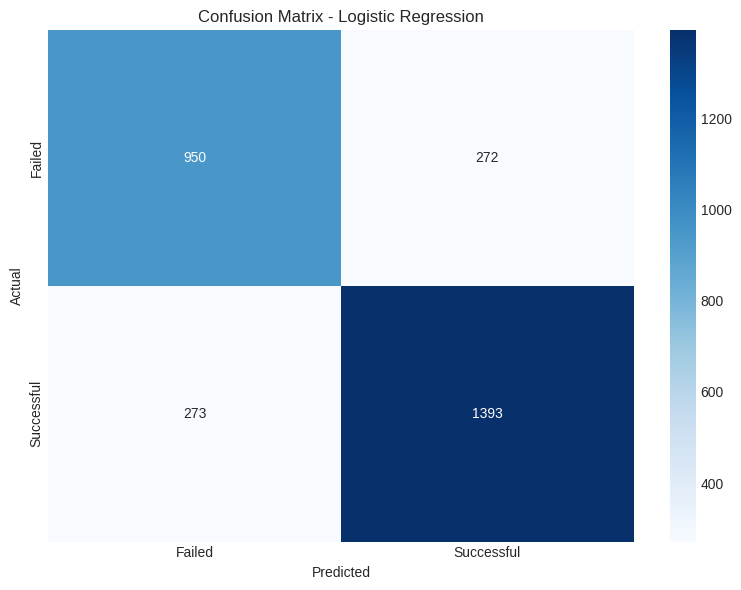

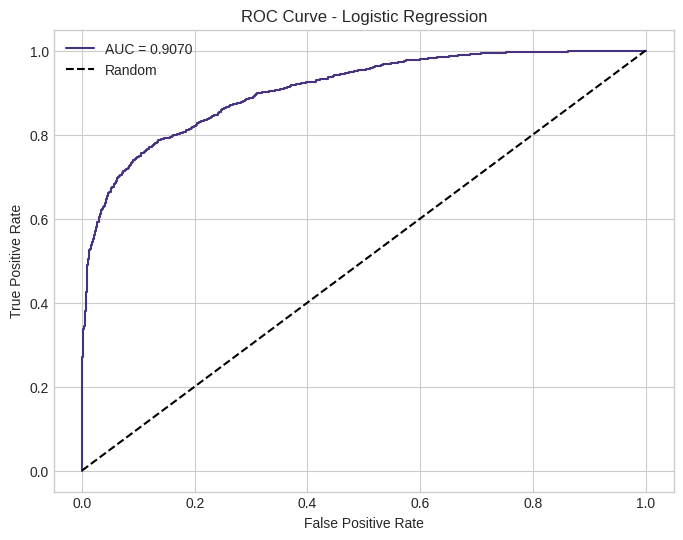

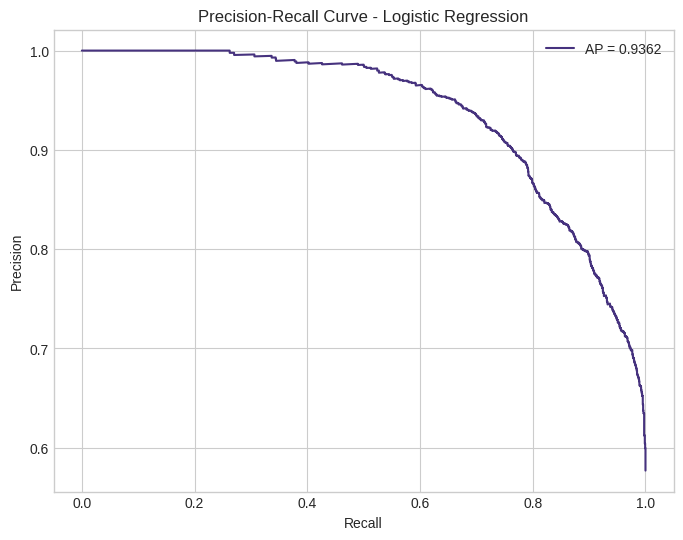

2025/04/25 16:15:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [17]:
model_results = {}
print("Training Logistic Regression baseline model...")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr_results = evaluate_model(lr, X_train_selected, X_test_selected, y_train, y_test, "Logistic Regression")
model_results['Logistic Regression'] = lr_results
log_model_to_mlflow(lr, lr_results, "Logistic Regression Baseline")

## Random Forest


Training Random Forest baseline model...

--- Random Forest Results ---
Training time: 4.00 seconds
Accuracy: 0.8148
Precision: 0.8528
Recall: 0.8205
F1 Score: 0.8363
ROC AUC: 0.9084
Average Precision: 0.9378


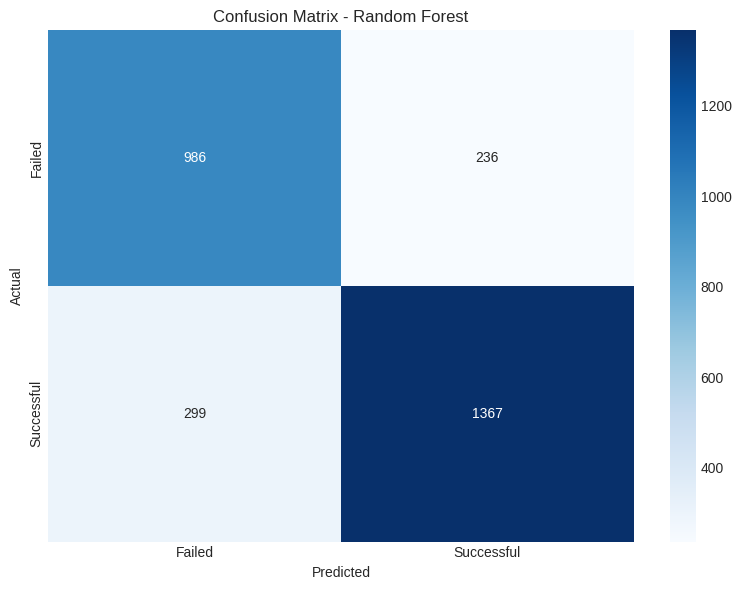

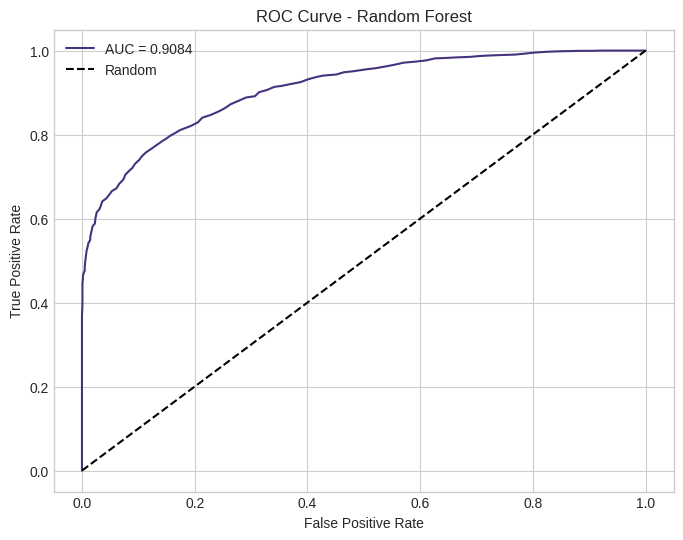

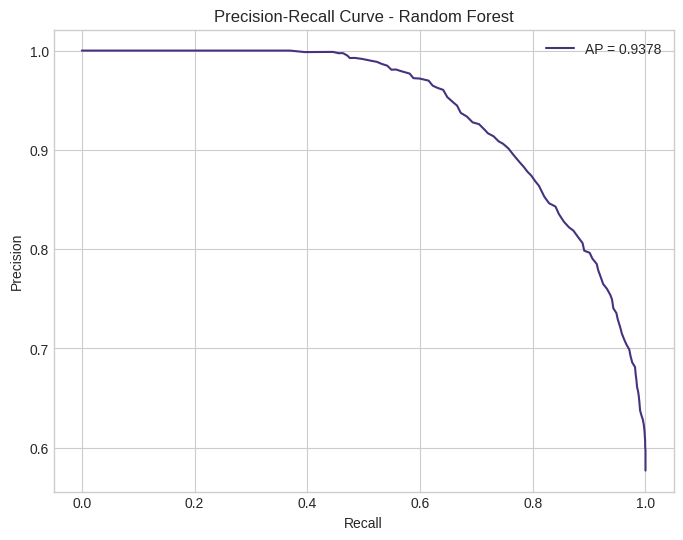

2025/04/25 16:17:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [18]:
print("\nTraining Random Forest baseline model...")
rf = RandomForestClassifier(random_state=42)
rf_results = evaluate_model(rf, X_train_selected, X_test_selected, y_train, y_test, "Random Forest")
model_results['Random Forest'] = rf_results
log_model_to_mlflow(rf, rf_results, "Random Forest Baseline")

##  XGBoost


Training XGBoost baseline model with GPU acceleration...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:17:53] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:17:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:17:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:17:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU t


--- XGBoost Results ---
Training time: 0.43 seconds
Accuracy: 0.8054
Precision: 0.8387
Recall: 0.8205
F1 Score: 0.8295
ROC AUC: 0.9012
Average Precision: 0.9339


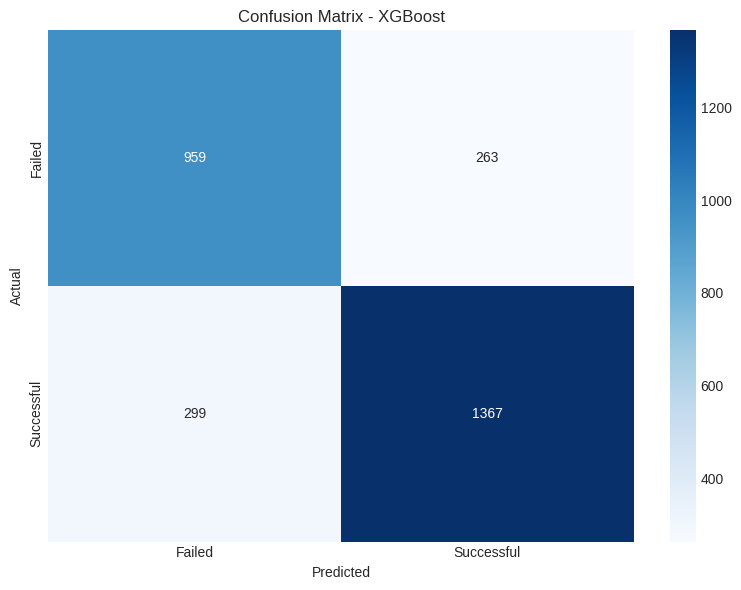

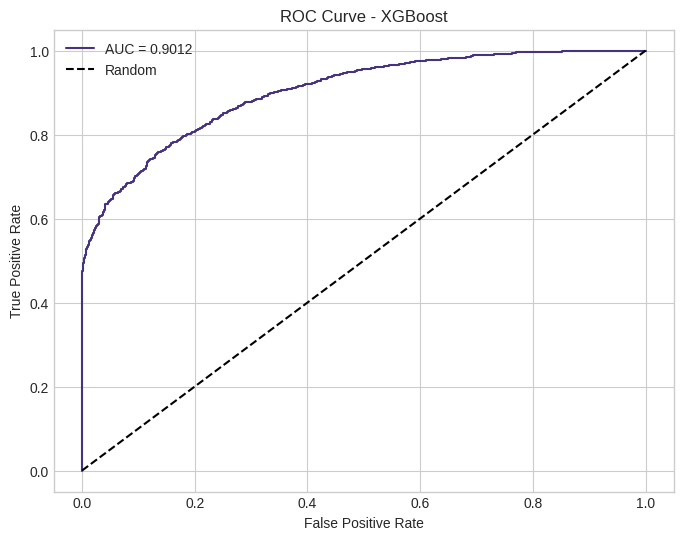

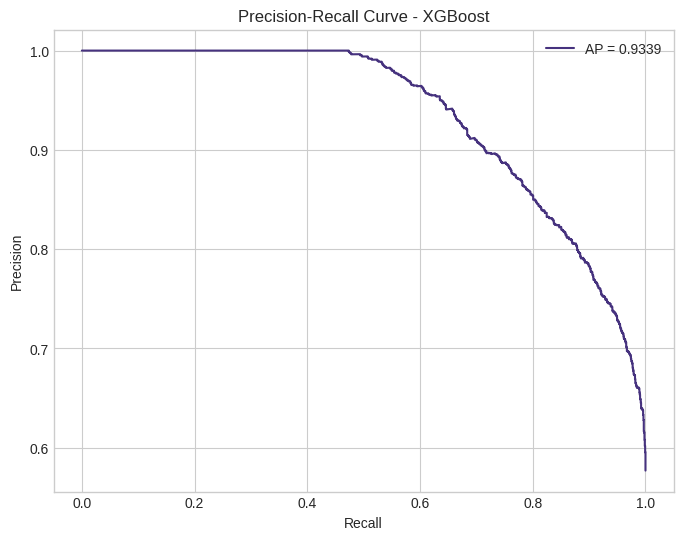

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:17:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/25 16:17:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [19]:
print("\nTraining XGBoost baseline model with GPU acceleration...")
xgb_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='gpu_hist',
    gpu_id=0
)
xgb_results = evaluate_model(xgb_model, X_train_selected, X_test_selected, y_train, y_test, "XGBoost")
model_results['XGBoost'] = xgb_results
log_model_to_mlflow(xgb_model, xgb_results, "XGBoost Baseline")

## MLPClassifier


Training MLPClassifier baseline model…

--- MLP Classifier Results ---
Training time: 8.47 seconds
Accuracy: 0.7940
Precision: 0.8174
Recall: 0.8277
F1 Score: 0.8225
ROC AUC: 0.8911
Average Precision: 0.9279


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


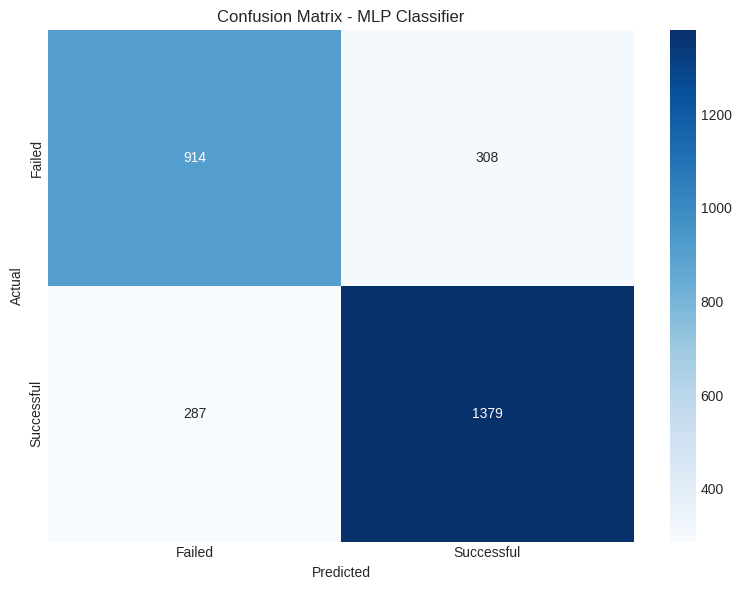

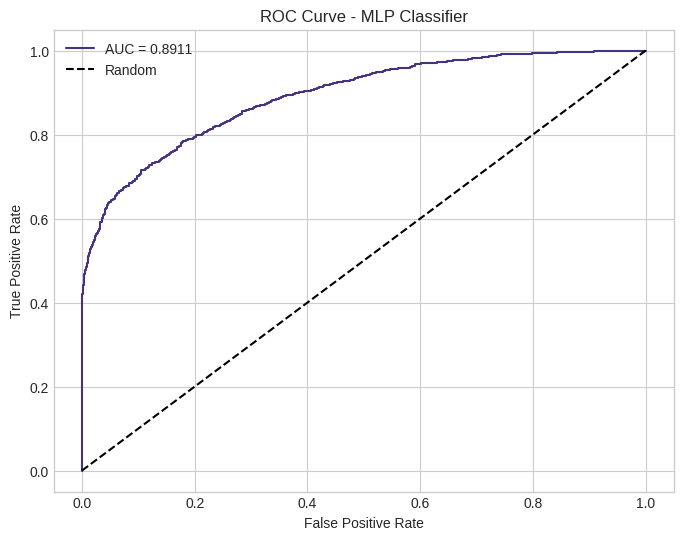

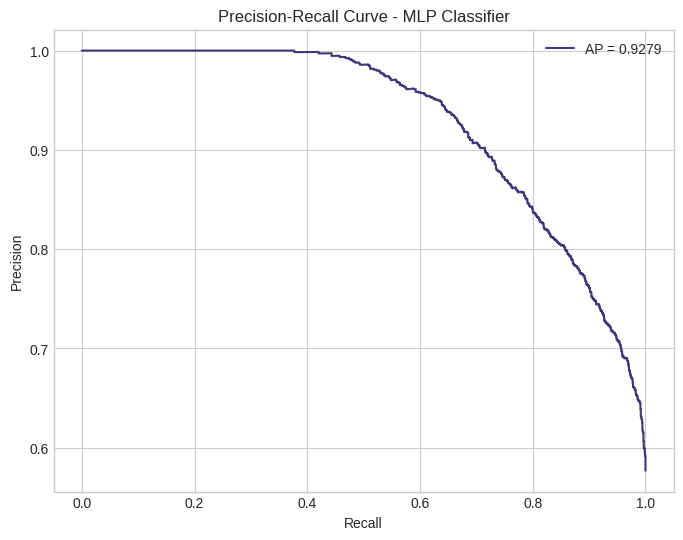

2025/04/25 16:18:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [20]:
print("\nTraining MLPClassifier baseline model…")
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42
)
mlp_results = evaluate_model(
    mlp,
    X_train_selected, X_test_selected,
    y_train, y_test,
    "MLP Classifier"
)
model_results['MLPClassifier'] = mlp_results
log_model_to_mlflow(mlp, mlp_results, "MLPClassifier Baseline")

## Compare baseline models

In [21]:
baseline_comparison = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [result['accuracy'] for result in model_results.values()],
    'Precision': [result['precision'] for result in model_results.values()],
    'Recall': [result['recall'] for result in model_results.values()],
    'F1 Score': [result['f1'] for result in model_results.values()],
    'ROC AUC': [result['roc_auc'] for result in model_results.values()],
    'Avg Precision': [result['avg_precision'] for result in model_results.values()],
    'Training Time (s)': [result['train_time'] for result in model_results.values()]
})

print("\nBaseline Model Comparison:")
print(baseline_comparison.sort_values('ROC AUC', ascending=False))


Baseline Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
1        Random Forest  0.814751   0.852776  0.820528  0.836341  0.908432   
0  Logistic Regression  0.811288   0.836637  0.836134  0.836385  0.907010   
2              XGBoost  0.805402   0.838650  0.820528  0.829490  0.901247   
3        MLPClassifier  0.793975   0.817427  0.827731  0.822547  0.891100   

   Avg Precision  Training Time (s)  
1       0.937757           3.995288  
0       0.936222           0.068827  
2       0.933939           0.431494  
3       0.927862           8.466838  


## Visualize model comparison

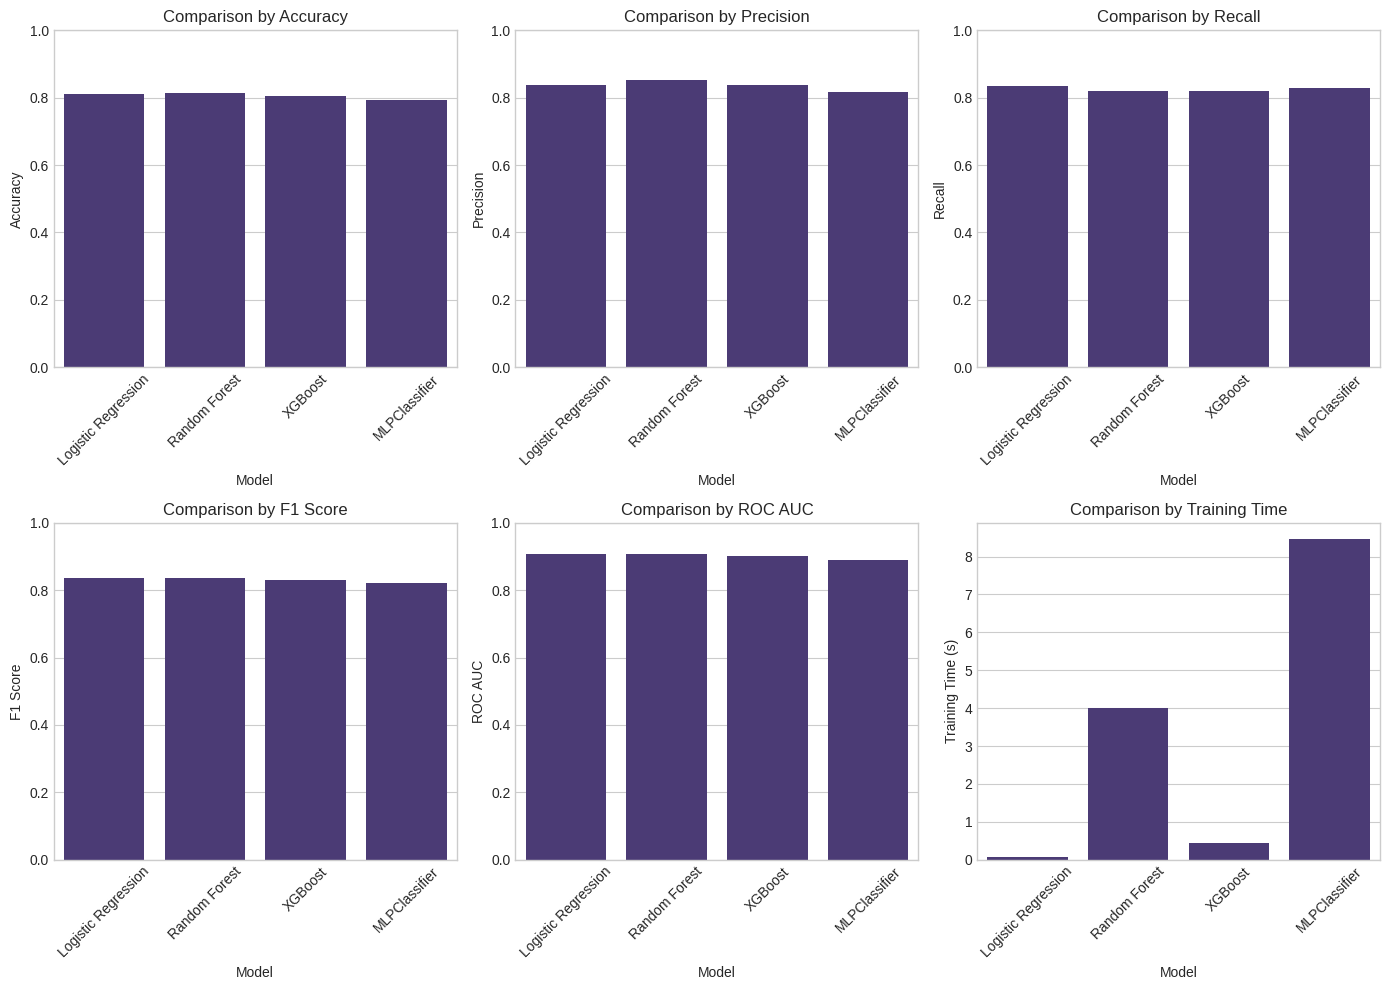

In [23]:
plt.figure(figsize=(14, 10))

# Plot different metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x='Model', y=metric, data=baseline_comparison)
    plt.xticks(rotation=45)
    plt.title(f'Comparison by {metric}')
    plt.ylim(0, 1)  # All these metrics are between 0 and 1

# Plot training time
plt.subplot(2, 3, 6)
sns.barplot(x='Model', y='Training Time (s)', data=baseline_comparison)
plt.xticks(rotation=45)
plt.title('Comparison by Training Time')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning with Optuna (Parallel Processing)

In [24]:
from joblib import parallel_backend

# Define optimization functions for each model type
def optimize_logistic_regression(trial):
    # Define hyperparameters to search
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    penalty = 'l2'
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    # Create model with hyperparameters
    model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        max_iter=1000,
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    )

    # Cross-validation score
    with parallel_backend('threading', n_jobs=-1):  # Use threading for parallel processing
        cv_scores = cross_val_score(
            model, X_train_selected, y_train,
            cv=StratifiedKFold(5, shuffle=True, random_state=42),
            scoring='roc_auc'
        )

    return cv_scores.mean()

def optimize_random_forest(trial):
    # Define hyperparameters to search
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create model with hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    )

    # Cross-validation score
    with parallel_backend('threading', n_jobs=-1):  # Use threading for parallel processing
        cv_scores = cross_val_score(
            model, X_train_selected, y_train,
            cv=StratifiedKFold(5, shuffle=True, random_state=42),
            scoring='roc_auc'
        )

    return cv_scores.mean()

# Define early stopping callback for efficient XGBoost training
def optimize_xgboost(trial):
    # Define hyperparameters to search
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    # Create model with hyperparameters - with GPU acceleration
    # Remove early_stopping_rounds parameter which causes the error
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist',  # Use GPU acceleration
        gpu_id=0,               # GPU device ID
        random_state=42,
        verbosity=0
    )

    # Cross-validation with parallel processing
    with parallel_backend('threading', n_jobs=-1):
        cv_scores = cross_val_score(
            model, X_train_selected, y_train,
            cv=StratifiedKFold(5, shuffle=True, random_state=42),
            scoring='roc_auc'
        )

    return cv_scores.mean()
def optimize_mlp(trial):
  # MLP hyperparams
  lr_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
  hidden_size = trial.suggest_int('hidden_layer_size', 50, 200)

  model = MLPClassifier(
        hidden_layer_sizes=(hidden_size,),
        learning_rate_init=lr_init,
        alpha=alpha,
        solver='adam',
        max_iter=200,
        random_state=42
    )
  cv = cross_val_score(
        model, X_train_selected, y_train,
        cv=StratifiedKFold(5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )
  return cv.mean()

## Run hyperparameter tuning for each model type with parallel processing

In [25]:
# Configure study for parallel processing
import os
from optuna.samplers import TPESampler

# Dictionary to store optimized models
optimized_models = {}

# Use TPE sampler for more efficient optimization
sampler = TPESampler(seed=42)

# Reduce number of trials for quicker execution but still good performance
n_trials = 20

## Logistic Regression

In [26]:
print("\nOptimizing Logistic Regression...")
lr_study = optuna.create_study(direction='maximize', sampler=sampler)
lr_study.optimize(optimize_logistic_regression, n_trials=n_trials)

print(f"Best Logistic Regression parameters: {lr_study.best_params}")
print(f"Best cross-validation ROC AUC: {lr_study.best_value:.4f}")

# Create optimized model
best_lr = LogisticRegression(
    **lr_study.best_params,
    max_iter=1000,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
optimized_models['Logistic Regression'] = best_lr

[I 2025-04-25 16:25:25,827] A new study created in memory with name: no-name-cd4d1125-1435-473c-8fad-ca06b064368e



Optimizing Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 1

Best Logistic Regression parameters: {'C': 9.915125650888614, 'solver': 'liblinear', 'penalty': 'l2'}
Best cross-validation ROC AUC: 0.9074


## Random Forest

In [27]:
print("\nOptimizing Random Forest...")
rf_study = optuna.create_study(direction='maximize', sampler=sampler)
rf_study.optimize(optimize_random_forest, n_trials=n_trials)

print(f"Best Random Forest parameters: {rf_study.best_params}")
print(f"Best cross-validation ROC AUC: {rf_study.best_value:.4f}")

# Create optimized model
best_rf = RandomForestClassifier(
    **rf_study.best_params,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
optimized_models['Random Forest'] = best_rf

[I 2025-04-25 16:27:23,429] A new study created in memory with name: no-name-7dda0a51-d831-499f-8e96-1421850591da



Optimizing Random Forest...


[I 2025-04-25 16:27:28,421] Trial 0 finished with value: 0.9032754553410545 and parameters: {'n_estimators': 58, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 0.9032754553410545.
[I 2025-04-25 16:27:36,201] Trial 1 finished with value: 0.9037234777786027 and parameters: {'n_estimators': 96, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 1 with value: 0.9037234777786027.
[I 2025-04-25 16:27:40,253] Trial 2 finished with value: 0.898140265216006 and parameters: {'n_estimators': 72, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.9037234777786027.
[I 2025-04-25 16:27:49,243] Trial 3 finished with value: 0.9030760341718074 and parameters: {'n_estimators': 139, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9037234777786027.
[I 2025

Best Random Forest parameters: {'n_estimators': 214, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}
Best cross-validation ROC AUC: 0.9081


## XGBoost

In [28]:
print("\nOptimizing XGBoost...")
xgb_study = optuna.create_study(direction='maximize', sampler=sampler)
xgb_study.optimize(optimize_xgboost, n_trials=n_trials)

print(f"Best XGBoost parameters: {xgb_study.best_params}")
print(f"Best cross-validation ROC AUC: {xgb_study.best_value:.4f}")

# Create optimized model with GPU acceleration
best_xgb = xgb.XGBClassifier(
    **xgb_study.best_params,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='gpu_hist',  # Use GPU acceleration
    gpu_id=0,                # GPU device ID
    random_state=42,
    n_jobs=-1                # Use all CPU cores for parts that can't use GPU
)
optimized_models['XGBoost'] = best_xgb

[I 2025-04-25 16:32:03,438] A new study created in memory with name: no-name-29784042-a986-4b7d-83e1-f0b9790442cb



Optimizing XGBoost...


[I 2025-04-25 16:32:08,176] Trial 0 finished with value: 0.908023770253428 and parameters: {'n_estimators': 283, 'max_depth': 13, 'learning_rate': 0.08622121759478739, 'subsample': 0.9485842360750871, 'colsample_bytree': 0.9214688307596458, 'min_child_weight': 2}. Best is trial 0 with value: 0.908023770253428.
[I 2025-04-25 16:32:11,543] Trial 1 finished with value: 0.9054109707624237 and parameters: {'n_estimators': 274, 'max_depth': 10, 'learning_rate': 0.1558428978238547, 'subsample': 0.9584365199693973, 'colsample_bytree': 0.7272013899887455, 'min_child_weight': 2}. Best is trial 0 with value: 0.908023770253428.
[I 2025-04-25 16:32:12,659] Trial 2 finished with value: 0.9068049698746229 and parameters: {'n_estimators': 107, 'max_depth': 8, 'learning_rate': 0.16155001304356414, 'subsample': 0.9442922333025374, 'colsample_bytree': 0.6027808522124762, 'min_child_weight': 6}. Best is trial 0 with value: 0.908023770253428.
[I 2025-04-25 16:32:13,665] Trial 3 finished with value: 0.90598

Best XGBoost parameters: {'n_estimators': 243, 'max_depth': 8, 'learning_rate': 0.02062955017866963, 'subsample': 0.6737446254494098, 'colsample_bytree': 0.7696301691979486, 'min_child_weight': 10}
Best cross-validation ROC AUC: 0.9117


## MLPClassifier

In [29]:
print("\nOptimizing MLPClassifier…")
mlp_study = optuna.create_study(direction='maximize', sampler=sampler)
mlp_study.optimize(optimize_mlp, n_trials=n_trials)
best_mlp = MLPClassifier(
    hidden_layer_sizes=(mlp_study.best_params['hidden_layer_size'],),
    learning_rate_init=mlp_study.best_params['learning_rate_init'],
    alpha=mlp_study.best_params['alpha'],
    solver='adam',
    max_iter=200,
    random_state=42
)
optimized_models['MLPClassifier'] = best_mlp


[I 2025-04-25 16:33:11,174] A new study created in memory with name: no-name-4c76f381-16e0-46c0-8ed8-86916fa6216d



Optimizing MLPClassifier…


<ipython-input-24-11e1c4c6935c>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
<ipython-input-24-11e1c4c6935c>:100: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
[I 2025-04-25 16:33:21,810] Trial 0 finished with value: 0.8734106472977329 and parameters: {'learning_rate_init': 0.003437788661779583, 'alpha': 8.053471030316099e-05, 'hidden_layer_size': 147}. Best is trial 0 with value: 0.8734106472977329.
<ipython-input-24-11e1c4c6935c>:99: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

## Evaluate Optimized Models


Evaluating optimized Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(



--- Optimized Logistic Regression Results ---
Training time: 0.22 seconds
Accuracy: 0.8130
Precision: 0.8392
Recall: 0.8361
F1 Score: 0.8376
ROC AUC: 0.9074
Average Precision: 0.9363


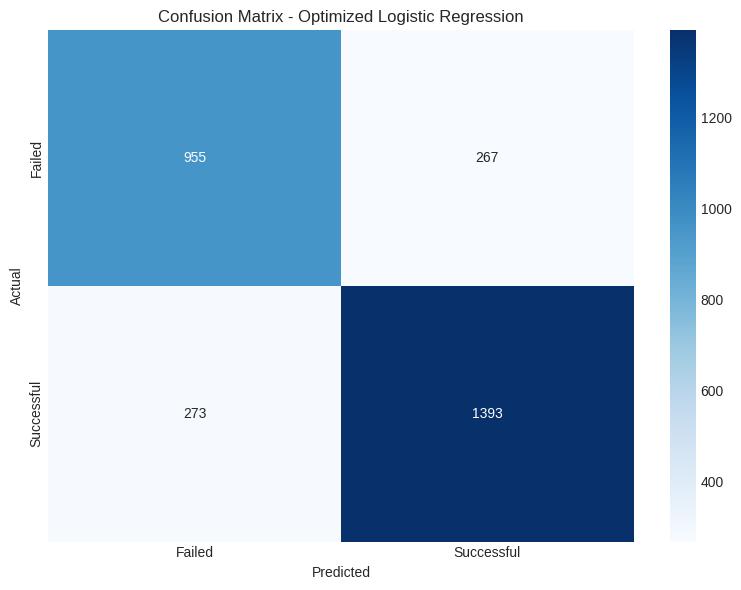

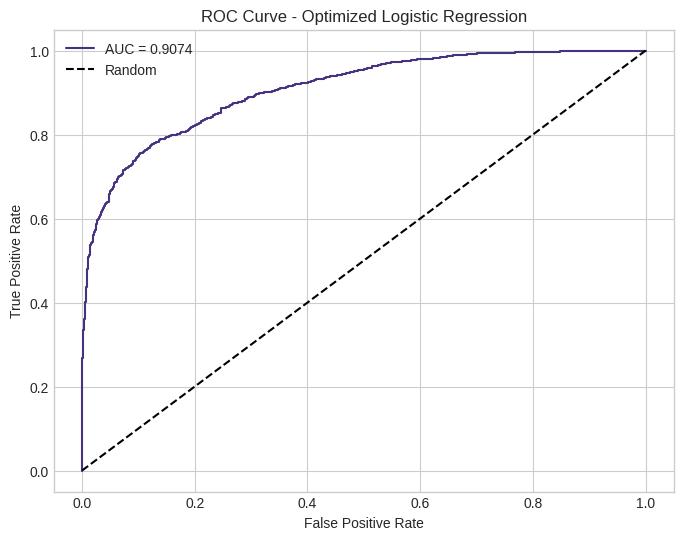

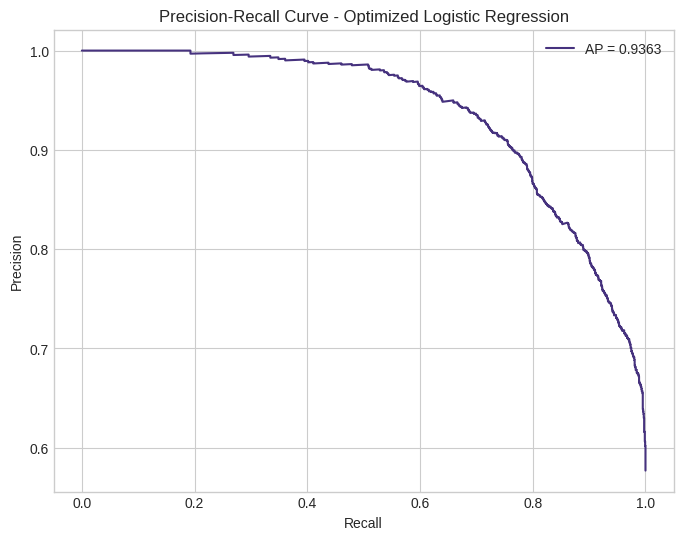

2025/04/25 16:40:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Evaluating optimized Random Forest...

--- Optimized Random Forest Results ---
Training time: 1.03 seconds
Accuracy: 0.8193
Precision: 0.8522
Recall: 0.8307
F1 Score: 0.8413
ROC AUC: 0.9115
Average Precision: 0.9409


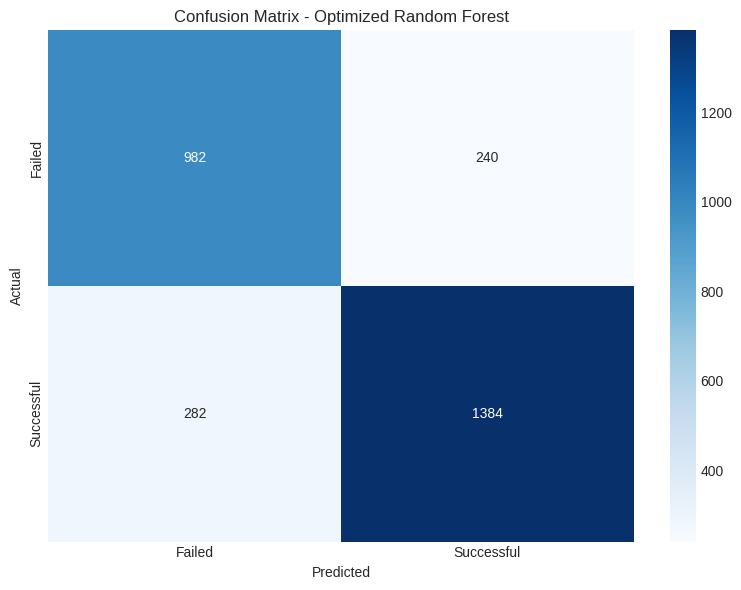

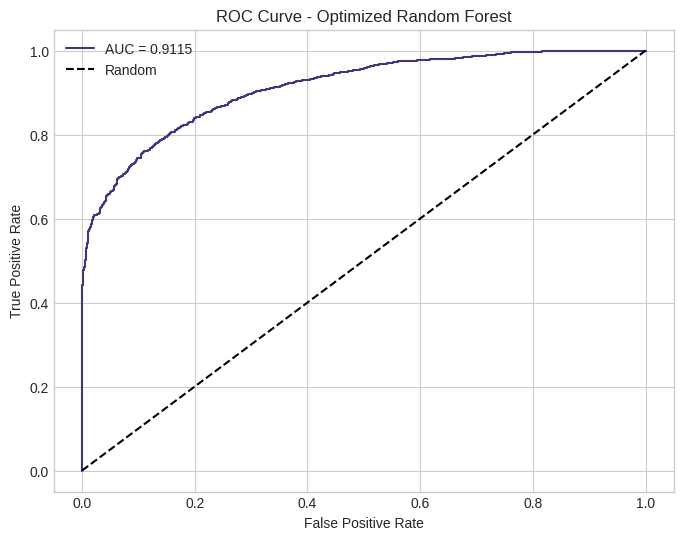

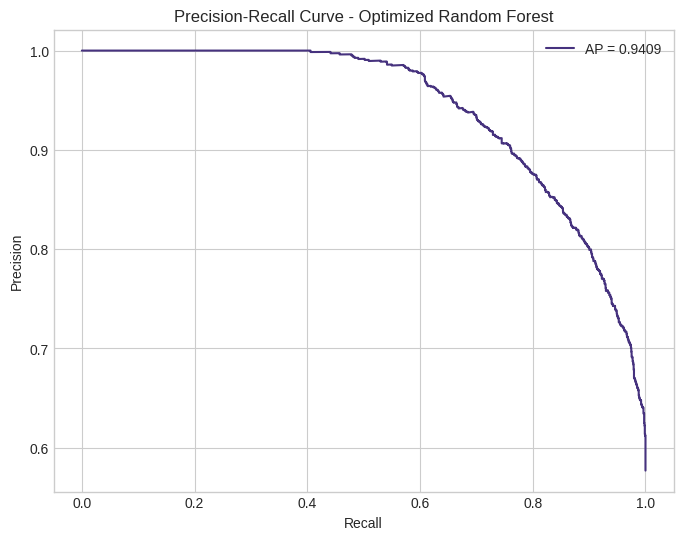

2025/04/25 16:40:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:40:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:40:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluating optimized XGBoost...

--- Optimized XGBoost Results ---
Training time: 0.64 seconds
Accuracy: 0.8168
Precision: 0.8516
Recall: 0.8265
F1 Score: 0.8389
ROC AUC: 0.9145
Average Precision: 0.9423


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:40:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


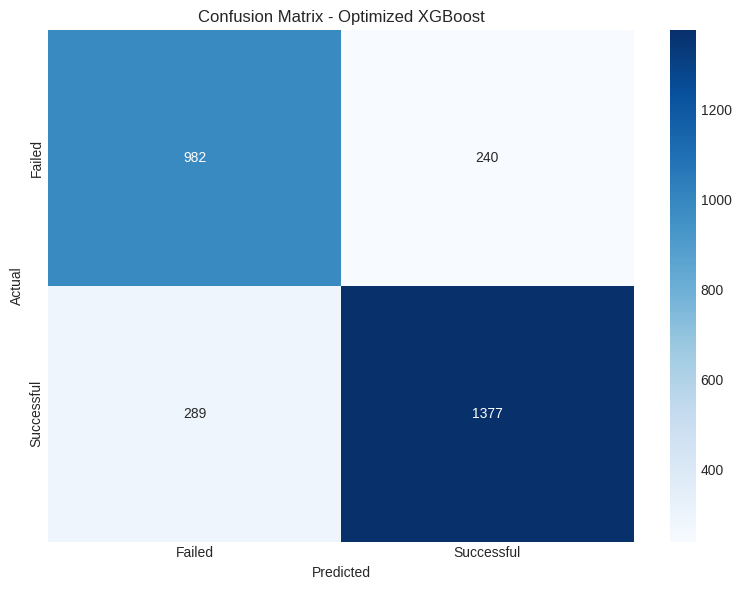

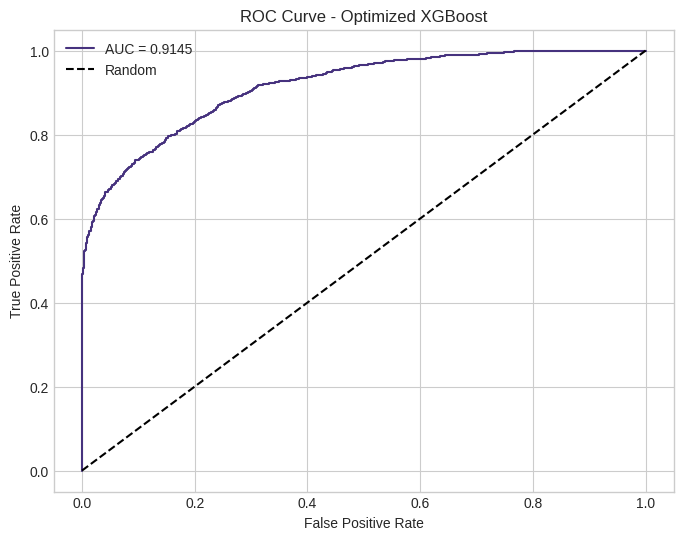

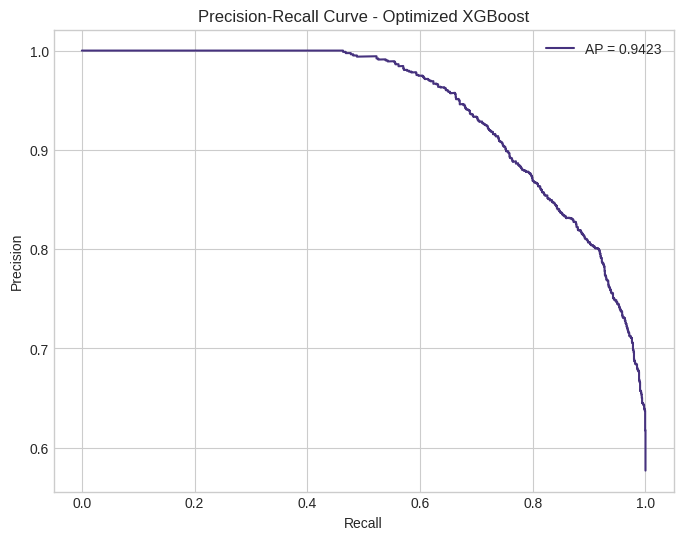

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:40:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/25 16:40:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Evaluating optimized MLPClassifier...

--- Optimized MLPClassifier Results ---
Training time: 9.59 seconds
Accuracy: 0.8161
Precision: 0.8497
Recall: 0.8277
F1 Score: 0.8386
ROC AUC: 0.9084
Average Precision: 0.9389


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


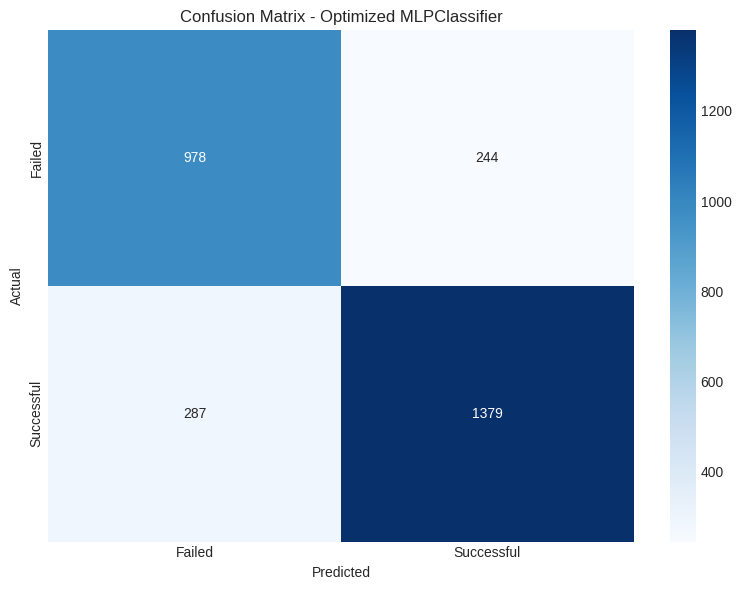

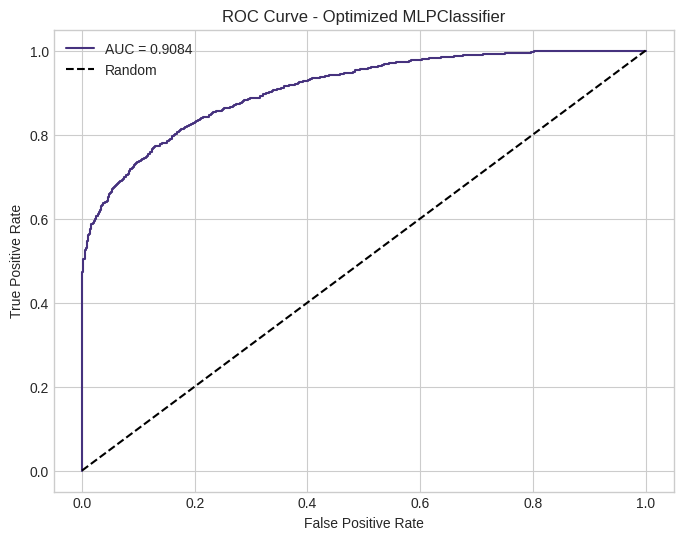

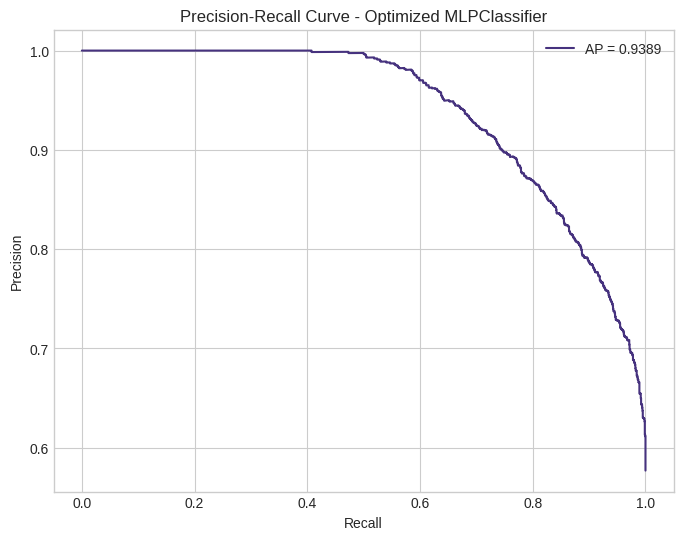

2025/04/25 16:40:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Optimized Model Comparison:
                           Model  Accuracy  Precision    Recall  F1 Score  \
2              Optimized XGBoost  0.816828   0.851577  0.826531  0.838867   
1        Optimized Random Forest  0.819252   0.852217  0.830732  0.841337   
3        Optimized MLPClassifier  0.816136   0.849661  0.827731  0.838553   
0  Optimized Logistic Regression  0.813019   0.839157  0.836134  0.837643   

    ROC AUC  Avg Precision  Training Time (s)  
2  0.914491       0.942336           0.641602  
1  0.911452       0.940854           1.027392  
3  0.908410       0.938910           9.588934  
0  0.907435       0.936342           0.218192  


In [30]:
# Dictionary to store optimized model results
optimized_results = {}

for model_name, model in optimized_models.items():
    print(f"\nEvaluating optimized {model_name}...")
    model_result = evaluate_model(
        model,
        X_train_selected, X_test_selected,
        y_train, y_test,
        f"Optimized {model_name}"
    )
    optimized_results[model_name] = model_result

    # pick up the right Optuna study’s best_params for logging
    if model_name == 'Logistic Regression':
        params = lr_study.best_params
    elif model_name == 'Random Forest':
        params = rf_study.best_params
    elif model_name == 'XGBoost':
        params = xgb_study.best_params
    elif model_name == 'MLPClassifier':
        params = mlp_study.best_params
    else:
        params = None

    log_model_to_mlflow(
        model,
        model_result,
        f"Optimized {model_name}",
        params
    )

# build a DataFrame to compare them
optimized_comparison = pd.DataFrame({
    'Model': [f"Optimized {name}" for name in optimized_results.keys()],
    'Accuracy': [res['accuracy'] for res in optimized_results.values()],
    'Precision': [res['precision'] for res in optimized_results.values()],
    'Recall': [res['recall'] for res in optimized_results.values()],
    'F1 Score': [res['f1'] for res in optimized_results.values()],
    'ROC AUC': [res['roc_auc'] for res in optimized_results.values()],
    'Avg Precision': [res['avg_precision'] for res in optimized_results.values()],
    'Training Time (s)': [res['train_time'] for res in optimized_results.values()]
})

print("\nOptimized Model Comparison:")
print(optimized_comparison.sort_values('ROC AUC', ascending=False))

##  Compare Baseline vs. Optimized Models




All Models Comparison (Sorted by ROC AUC):
                           Model  Accuracy  Precision    Recall  F1 Score  \
2              Optimized XGBoost  0.816828   0.851577  0.826531  0.838867   
1        Optimized Random Forest  0.819252   0.852217  0.830732  0.841337   
1                  Random Forest  0.814751   0.852776  0.820528  0.836341   
3        Optimized MLPClassifier  0.816136   0.849661  0.827731  0.838553   
0  Optimized Logistic Regression  0.813019   0.839157  0.836134  0.837643   
0            Logistic Regression  0.811288   0.836637  0.836134  0.836385   
2                        XGBoost  0.805402   0.838650  0.820528  0.829490   
3                  MLPClassifier  0.793975   0.817427  0.827731  0.822547   

    ROC AUC  Avg Precision  Training Time (s)  
2  0.914491       0.942336           0.641602  
1  0.911452       0.940854           1.027392  
1  0.908432       0.937757           3.995288  
3  0.908410       0.938910           9.588934  
0  0.907435       0.93

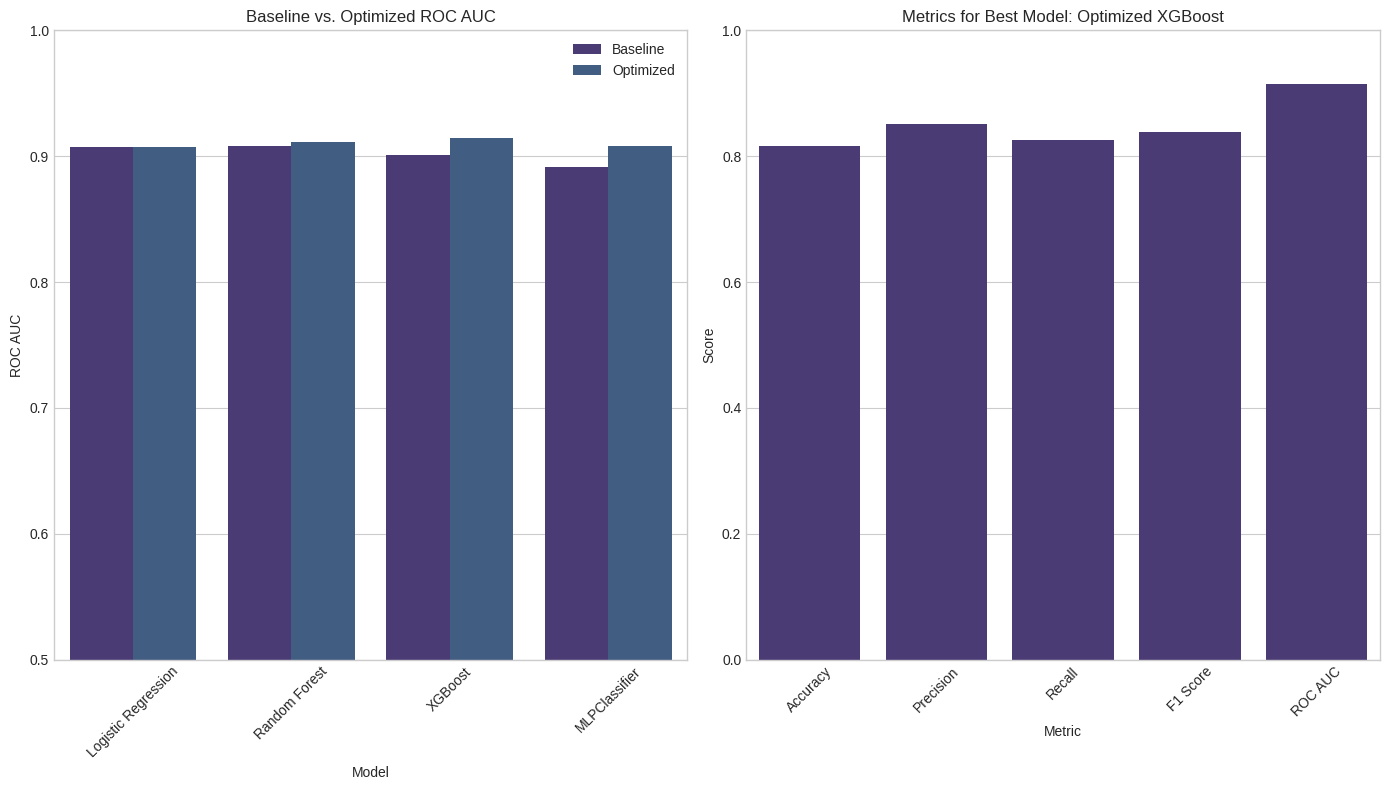

In [31]:
# Combine baseline and optimized results for comparison
all_models_comparison = pd.concat([
    baseline_comparison,
    optimized_comparison
])

# Sort by ROC AUC (primary metric)
all_models_comparison = all_models_comparison.sort_values('ROC AUC', ascending=False)

print("\nAll Models Comparison (Sorted by ROC AUC):")
print(all_models_comparison)

# Visualize improvement from baseline to optimized
plt.figure(figsize=(14, 8))

# Plot ROC AUC comparison
metric = 'ROC AUC'  # Key metric for comparison
plt.subplot(1, 2, 1)
baseline_data = baseline_comparison[['Model', metric]].copy()
baseline_data['Type'] = 'Baseline'
optimized_data = optimized_comparison[['Model', metric]].copy()
optimized_data['Model'] = optimized_data['Model'].str.replace('Optimized ', '')
optimized_data['Type'] = 'Optimized'

combined_data = pd.concat([baseline_data, optimized_data])
sns.barplot(x='Model', y=metric, hue='Type', data=combined_data)
plt.title(f'Baseline vs. Optimized {metric}')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)  # Adjusted for better visualization
plt.legend(title='')

# Plot multiple metrics for the best model
best_model_name = all_models_comparison.iloc[0]['Model']
plt.subplot(1, 2, 2)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
best_model_metrics = all_models_comparison.loc[all_models_comparison['Model'] == best_model_name, metrics_to_plot].melt()
sns.barplot(x='variable', y='value', data=best_model_metrics)
plt.title(f'Metrics for Best Model: {best_model_name}')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')

plt.tight_layout()
plt.show()

## Feature Importance Analysis for Best Model


Analyzing feature importance for the best model: Optimized XGBoost


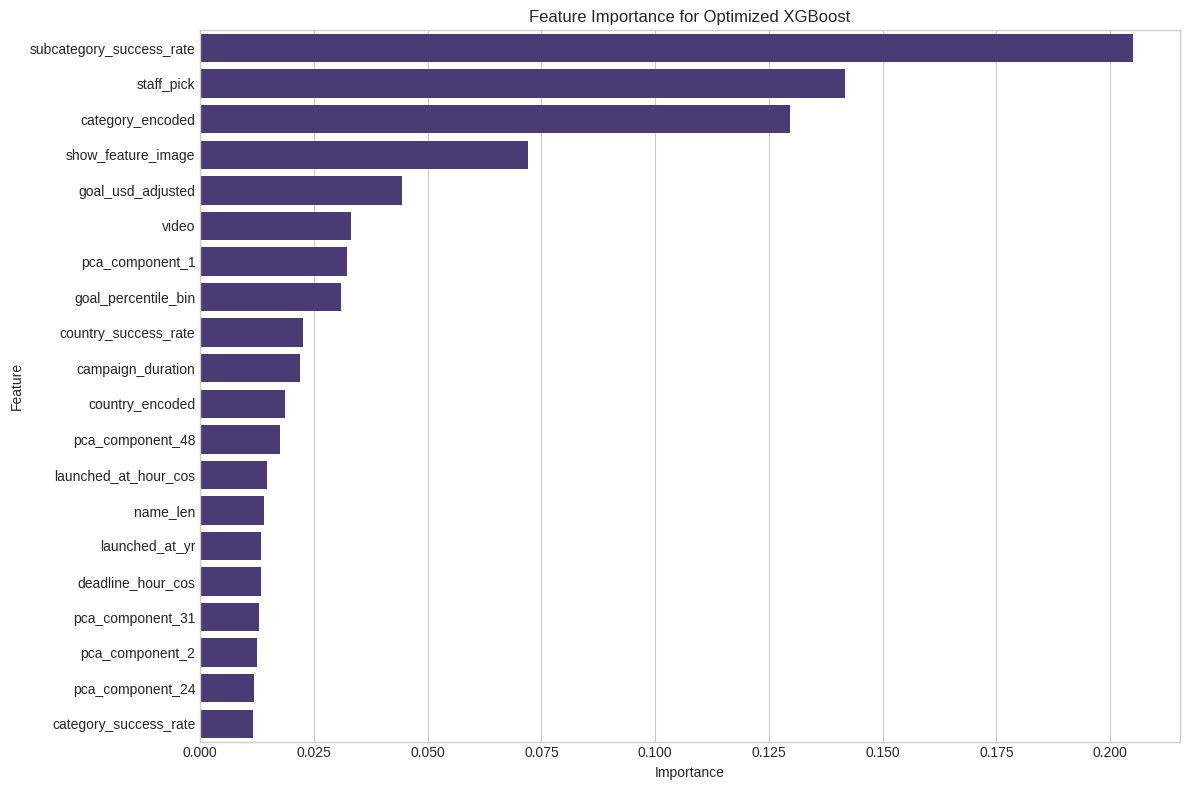


Calculating SHAP values for interpretation...


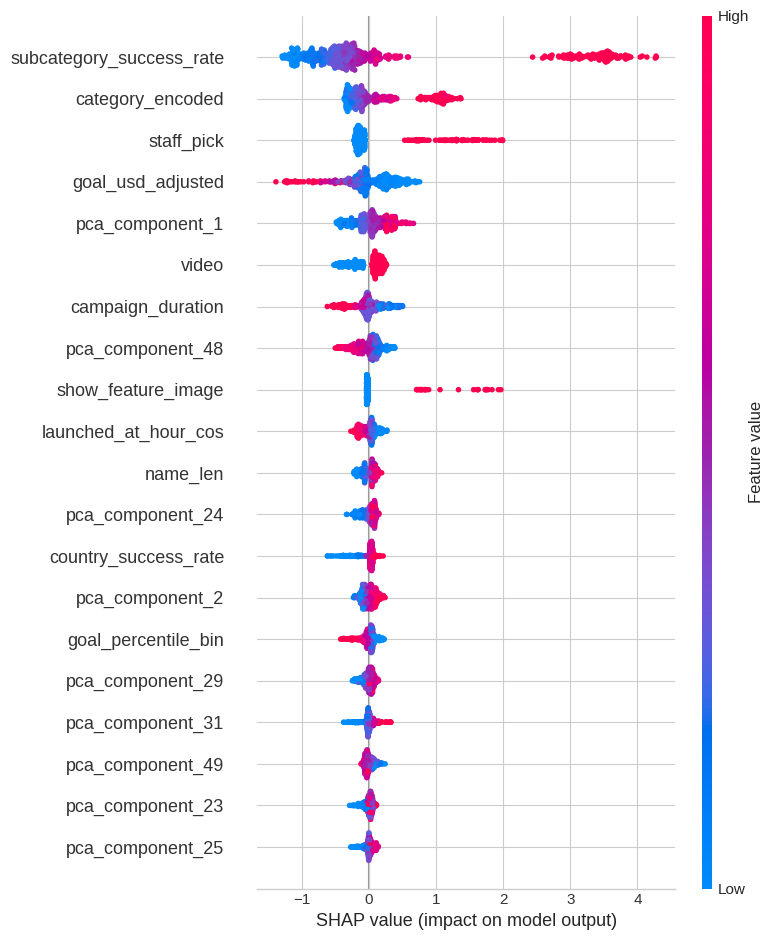

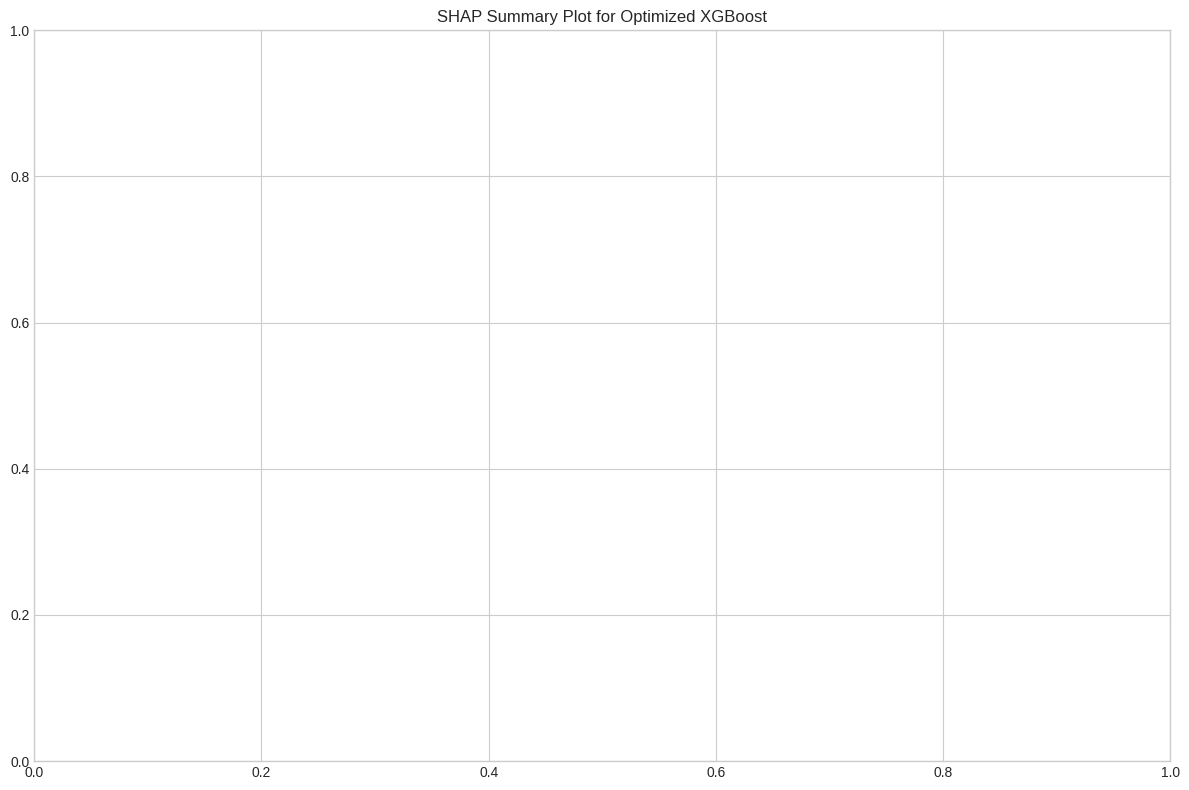

<Figure size 1000x600 with 0 Axes>

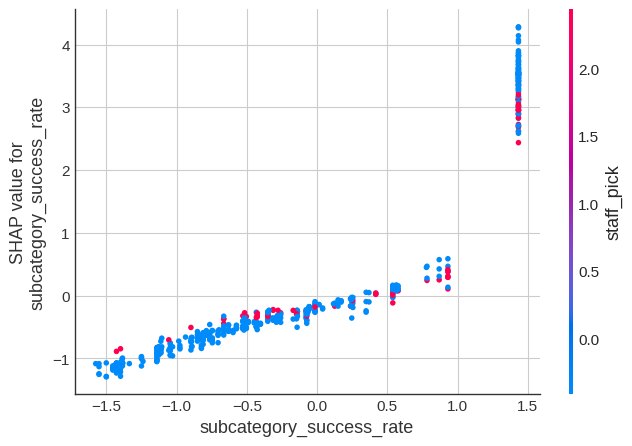

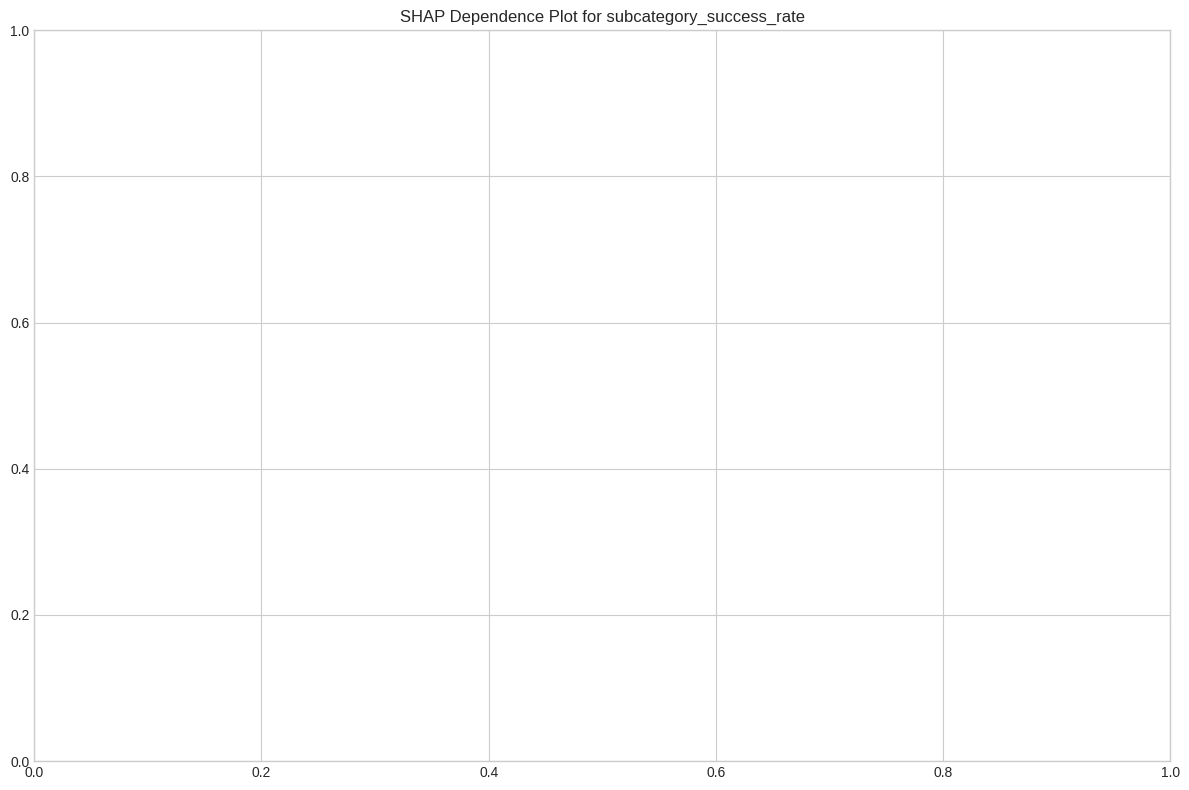

<Figure size 1000x600 with 0 Axes>

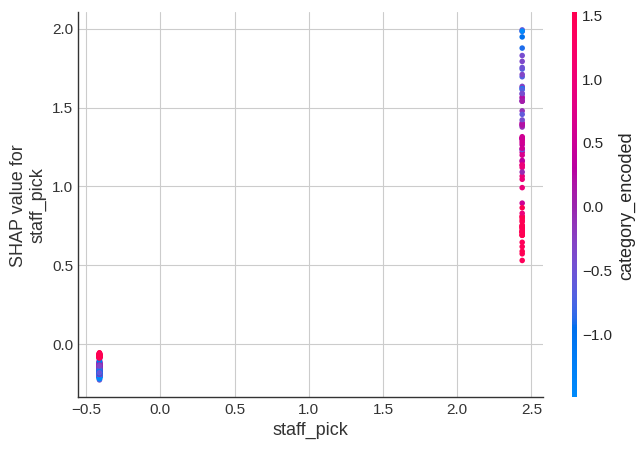

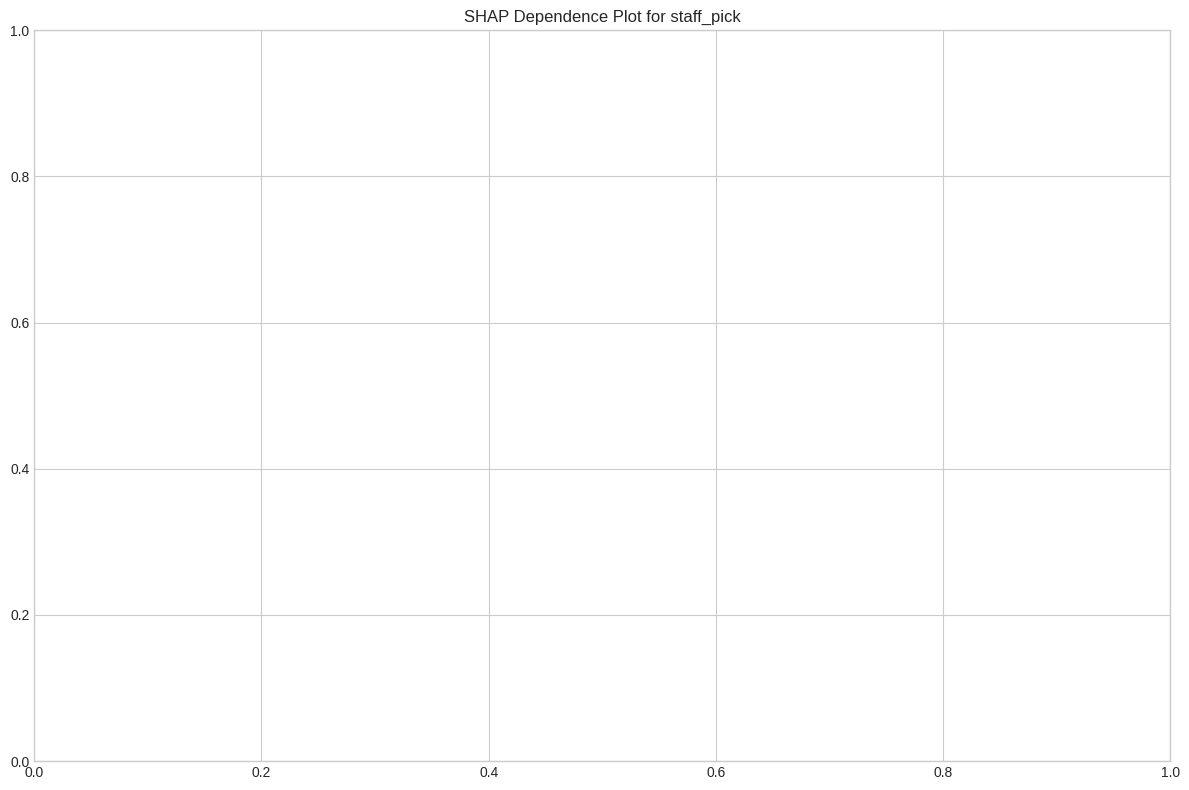

In [32]:
# Identify the best model
best_model_name = all_models_comparison.iloc[0]['Model']
print(f"\nAnalyzing feature importance for the best model: {best_model_name}")

# Get the actual model object
if 'Optimized' in best_model_name:
    clean_name = best_model_name.replace('Optimized ', '')
    best_model = optimized_models[clean_name]
    best_model_results = optimized_results[clean_name]
else:
    best_model = model_results[best_model_name]['model']
    best_model_results = model_results[best_model_name]

# Get feature importance based on model type
if 'Logistic Regression' in best_model_name:
    # For logistic regression, use coefficients
    importance = np.abs(best_model.coef_[0])
    feature_importance = pd.DataFrame({
        'Feature': X_train_selected.columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Feature Importance for {best_model_name}')
    plt.tight_layout()
    plt.show()

elif 'Random Forest' in best_model_name or 'XGBoost' in best_model_name:
    # For tree-based models, use feature_importances_
    importance = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X_train_selected.columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Feature Importance for {best_model_name}')
    plt.tight_layout()
    plt.show()

    # SHAP values for a deeper understanding
    print("\nCalculating SHAP values for interpretation...")
    try:
        shap_sample = X_test_selected.sample(500, random_state=42) \
            if X_test_selected.shape[0] > 500 else X_test_selected
        explainer = shap.Explainer(best_model)
        shap_values = explainer(shap_sample)

        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, shap_sample)
        plt.title(f'SHAP Summary Plot for {best_model_name}')
        plt.tight_layout()
        plt.show()

        top_feats = feature_importance.head(2)['Feature'].tolist()
        for feat in top_feats:
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(feat, shap_values.values, shap_sample,
                                 feature_names=X_train_selected.columns)
            plt.title(f'SHAP Dependence Plot for {feat}')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error calculating SHAP values: {e}")
        print("Continuing without SHAP analysis...")

elif 'MLPClassifier' in best_model_name:
    # For MLP, average absolute weights from the input layer as proxy importance
    weights = best_model.coefs_[0]  # shape (n_features, n_hidden)
    importance = np.mean(np.abs(weights), axis=1)
    feature_importance = pd.DataFrame({
        'Feature': X_train_selected.columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Feature Importance for {best_model_name} (MLP coefficients)')
    plt.tight_layout()
    plt.show()

else:
    print(f"No built-in feature importance available for {best_model_name}, skipping this step.")

## Learning Curves Analysis


Analyzing learning curves for the best model: Optimized XGBoost


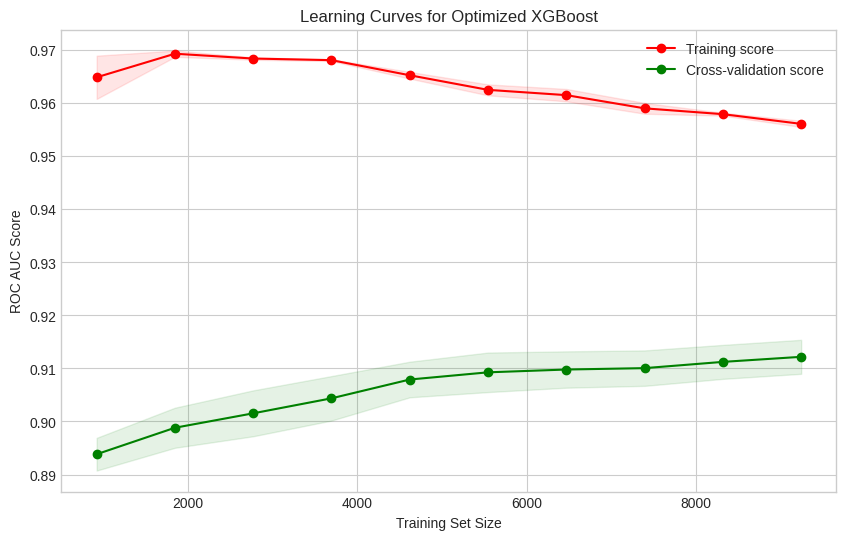

Final gap between training and validation scores: 0.0439
The model shows good fit (similar training and validation scores at a good level).


In [33]:
# Analyze learning curves for the best model
from sklearn.model_selection import learning_curve

print(f"\nAnalyzing learning curves for the best model: {best_model_name}")

# Define train sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_selected, y_train,
    train_sizes=train_sizes,
    cv=StratifiedKFold(5),
    scoring='roc_auc',
    n_jobs=-1
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.title(f'Learning Curves for {best_model_name}')
plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Interpretation
gap = train_mean[-1] - test_mean[-1]
print(f"Final gap between training and validation scores: {gap:.4f}")

if gap > 0.05:
    print("The model shows signs of overfitting (high training score, lower validation score).")
    print("Consider more regularization or simpler model.")
elif test_mean[-1] < 0.7:
    print("The model shows signs of underfitting (low validation score).")
    print("Consider more complex model or additional features.")
else:
    print("The model shows good fit (similar training and validation scores at a good level).")

## Save Best Model

In [34]:
# Save the best model
import joblib

# Create a complete pipeline with the best model
best_model_pipeline = Pipeline([
    ('scaler', scaler),
    ('model', best_model)
])

# Fit the pipeline on the full training data
best_model_pipeline.fit(X_train, y_train)

# Save pipeline
joblib.dump(best_model_pipeline, 'best_kickstarter_model_pipeline.pkl')
print(f"\nBest model saved as 'best_kickstarter_model_pipeline.pkl'")

# Save feature list for future reference
with open('selected_features.txt', 'w') as f:
    f.write('\n'.join(selected_features_rfecv.tolist()))
print("Selected features saved as 'selected_features.txt'")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best model saved as 'best_kickstarter_model_pipeline.pkl'
Selected features saved as 'selected_features.txt'


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [35]:
from google.colab import files
files.download('best_kickstarter_model_pipeline.pkl')
files.download('selected_features.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>